## Information extraction

In [1]:
# functions for information extraction
import pandas as pd
import ast
import re

# extract configuration information
def extract_config(lines):
    switch_config_target = "Switch configurations:"
    pctrl_only_target = "'--pctrl-only'"
    data = {}
    found_switch_config = False
    for _, line in enumerate(lines):
        if pctrl_only_target in line:
            pctrl_only_str = line.strip().replace("--", "").split(':')[1].strip()
            pctrl_only = ast.literal_eval(pctrl_only_str)
            data['pctrl_only'] = pctrl_only[0]
        elif switch_config_target in line:
            found_switch_config = True
        elif found_switch_config:
            # Safely evaluate the config string to a Python list containing a dictionary
            item_list = ast.literal_eval(line)
            if isinstance(item_list, list) and len(item_list) > 0 and isinstance(item_list[0], dict):
                record = item_list[0]
                ctrl_id = record.get('ctrl_id')
                thresh = record.get('thresh', {})
                time_delay = thresh.get('time_delay')
                cross_lane_headway = thresh.get('cross_lane_headway')
                data['ctrl_id'] = ctrl_id
                data['time_delay'] = time_delay
                data['cross_lane_headway'] = cross_lane_headway        
            found_switch_config = False  
    return data

# extract delay time
def extract_det_delay_time(lines):
    target = '--deterministic-delay'
    for _, line in enumerate(lines):
        if target in line:
            target_str = line.split(':')[1].replace("'", "").replace(",", "").strip()
            target_val = float(target_str)
            return target_val

# extract switch probabilities
def extract_switch_probs(lines):
    _dict = {}
    for line in lines:
        if line.startswith("[probabilities]"):
            # Use regular expression to find all numbers in the line
            numbers_str = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            if len(numbers_str) >= 2:
                try:
                    _dict["prob_pri_ctrl"] = float(numbers_str[0])
                    _dict["prob_sec_ctrl"] = 1 - float(numbers_str[0])
                except ValueError:
                    print(f"Warning: Could not convert first two elements to numbers in line: {line.strip()}")
    return _dict

# extract exit probabilities 
def extract_exit_probs(lines):
    _dict = {}
    for line in lines:
        if line.startswith("[counts]"):
            # Use regular expression to find all numbers in the line
            numbers_str = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            if len(numbers_str) >= 3:
                try:
                    num1 = int(numbers_str[1])
                    num2 = int(numbers_str[2])
                    if num1 * num2 < 0 or num1 + num2 <= 0:
                        raise ValueError("Both counts must be non-negative and at least one count must be positive")
                    p = num1 / float(num1 + num2)
                    _dict["prob_exit_sec_ctrl"] = p
                    _dict["prob_stay_in_sec_ctrl"] = 1 - p
                except ValueError:
                    print(f"Warning: Could not convert first three elements to numbers in line: {line.strip()}")
    return _dict

def extract_metrics_data_to_df(lines):
    extracted_data = [] 
    for line in lines:
        if line.startswith("[data]"):
                data_part = line[len("[data]"):].strip()
                pairs = data_part.split(', ')
                data_dict = {}
                for pair in pairs:
                    if ':' in pair:
                        key, value = pair.split(': ', 1)
                        data_dict[key.strip()] = value.strip()
                extracted_data.append(data_dict)
    if extracted_data:
        df = pd.DataFrame(extracted_data)
        df['headway'] = df['headway'].astype('float')
        # df['cross_lane_headway'] = df['cross_lane_headway'].astype('float')
        df['ttc'] = df['ttc'].astype('float')
        def bool_str_to_num(x):
            if x=='True':
                return 1  
            else:
                return 0
        df['on lane'] = df['on lane'].apply(bool_str_to_num)
        df = df.drop(['cross_lane_headway'], axis=1)
        return df
    else:
        raise ValueError("Empty data")  # Return an empty DataFrame

HEADWAY_THRESH = 7
TTC_THRESH = 70
print(f"HEADWAY_THRESH = {HEADWAY_THRESH}")
print(f"TTC_THRESH = {TTC_THRESH}")

# extract metrics
def generate_metrics_statistics(lines, headway_thresh=HEADWAY_THRESH, ttc_thresh=TTC_THRESH):     
    df = extract_metrics_data_to_df(lines)
    n_rows = len(df)
    proportions = {}

    for val3 in [0, 1]:
        for op2 in ['le', 'gt']:
            for op1 in ['le', 'gt']:
                subset_name = f"headway_{op1}_ttc_{op2}_on_lane_{val3}"

                condition1 = (df.iloc[:, 0] <= headway_thresh) if op1 == 'le' else (df.iloc[:, 0] > headway_thresh)
                condition2 = (df.iloc[:, 1] <= ttc_thresh) if op2 == 'le' else (df.iloc[:, 1] > ttc_thresh)
                condition3 = (df.iloc[:, 2] == val3)

                subset = df[condition1 & condition2 & condition3]
                proportions[subset_name] = len(subset) / n_rows if n_rows > 0 else 0.0

    return proportions

HEADWAY_THRESH = 7
TTC_THRESH = 70


## Experiment 1

In [2]:
import os
# directory of input data for exp 1
input_dir_1 = os.getcwd() + "/out/highway_env_continuous_actions/experiment/run1"

In [3]:
list_of_dfs = []
i = 0
for root, _, files in os.walk(input_dir_1):
        for file in files:
            if file.endswith("log.txt"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r') as f:
                        lines = f.readlines()   
                        dt = extract_det_delay_time(lines)           
                        i += 1
                        df = extract_metrics_data_to_df(lines)
                        list_of_dfs.append((dt, df))
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
import pandas as pd
list_of_dfs.sort(key=lambda item: item[0])

In [4]:
exp1_res_list = [];
for dt, df in list_of_dfs:
    headway_mean = df["headway"].mean()
    ttc_qt = df["ttc"].quantile(0.1)
    on_lane_mean = df["on lane"].mean()
    exp1_res_list.append([dt, headway_mean, ttc_qt, on_lane_mean])
column_names = ["delay_time", "headway_mean", "ttc_10pt", "on_lane_prob"]
exp1_res = pd.DataFrame(exp1_res_list, columns=column_names)
exp1_res

,delay_time,headway_mean,ttc_10pt,on_lane_prob
0,0.00,5.599308,28.00644,0.999946
1,0.05,5.505549,27.82746,1.000000
2,0.10,4.669603,24.97830,0.999946
3,0.15,4.552694,20.65444,0.967215
4,0.20,4.855820,16.87709,0.768350
5,0.25,4.866956,16.54985,0.755695
6,0.30,5.036633,11.70912,0.459351
7,0.35,4.891624,9.51423,0.407633
8,0.40,5.110903,8.71588,0.367579
9,0.45,5.083313,8.84193,0.362171


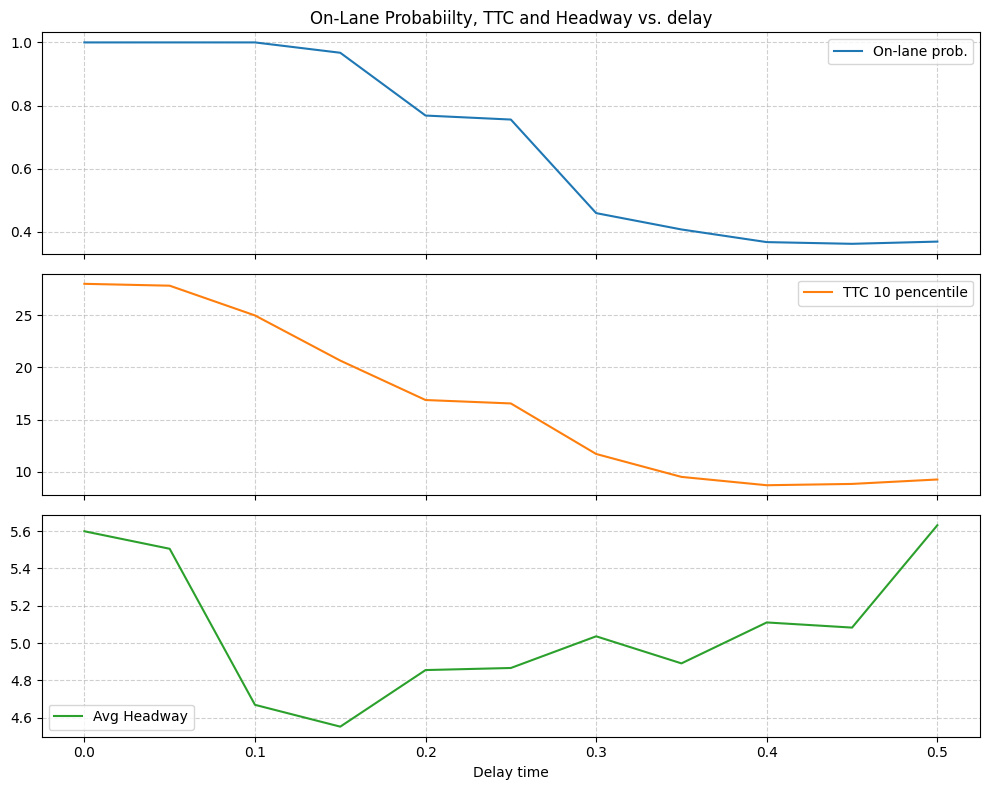

In [5]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
# 3 rows, 1 column, sharing the x-axis
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot each column on a different subplot
axes[0].plot(exp1_res['delay_time'], exp1_res['on_lane_prob'], label='On-lane prob.', color='C0') # Use 'C0', 'C1', ... for default colors
axes[1].plot(exp1_res['delay_time'], exp1_res['ttc_10pt'], label='TTC 10 pencentile', color='C1')
axes[2].plot(exp1_res['delay_time'], exp1_res['headway_mean'], label='Avg Headway', color='C2')

# Add titles and labels
axes[0].set_title('On-Lane Probabiilty, TTC and Headway vs. delay') # Main title or set suptitle on fig
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[2].set_xlabel('Delay time') # Only the bottom subplot needs the x-label

# Add legends to each subplot
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Optional: Add grid
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()
# Adjust layout to prevent the suptitle from overlapping the top plot
#fig.suptitle('Data from Columns b, c, and d vs. a (Separate Scales)', y=1.02)

# Show the plot
plt.show()

## Experiment 2

In [6]:
import os
input_dir_2 = os.getcwd() + "/out/highway_env_continuous_actions/experiment/run2"

In [ ]:
'''
import ast
def _extract_config(lines):
    switch_config_target = "Switch configurations:"
    pctrl_only_target = "'--pctrl-only'"
    data = {}
    found_switch_config = False
    for _, line in enumerate(lines):
        if pctrl_only_target in line:
            pctrl_only_str = line.strip().replace("--", "").split(':')[1].strip()
            pctrl_only = ast.literal_eval(pctrl_only_str)
            data['pctrl_only'] = pctrl_only[0]
        elif switch_config_target in line:
            found_switch_config = True
        elif found_switch_config:
            # Safely evaluate the config string to a Python list containing a dictionary
            item_list = ast.literal_eval(line)
            if isinstance(item_list, list) and len(item_list) > 0 and isinstance(item_list[0], dict):
                record = item_list[0]
                ctrl_id = record.get('ctrl_id')
                thresh = record.get('thresh', {})
                time_delay = thresh.get('time_delay')
                cross_lane_headway = thresh.get('cross_lane_headway')
                data['ctrl_id'] = ctrl_id
                data['time_delay'] = time_delay
                data['cross_lane_headway'] = cross_lane_headway        
            found_switch_config = False  
    return data

def _extract_switch_probs(lines):
    _dict = {}
    for line in lines:
        if line.startswith("[probabilities]"):
            # Use regular expression to find all numbers in the line
            numbers_str = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            if len(numbers_str) >= 2:
                try:
                    _dict["prob_pri_ctrl"] = float(numbers_str[0])
                    _dict["prob_sec_ctrl"] = 1 - float(numbers_str[0])
                except ValueError:
                    print(f"Warning: Could not convert first two elements to numbers in line: {line.strip()}")
    return _dict

def _extract_exit_probs(lines):
    _dict = {}
    for line in lines:
        if line.startswith("[counts]"):
            # Use regular expression to find all numbers in the line
            numbers_str = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            if len(numbers_str) >= 3:
                try:
                    num1 = int(numbers_str[1])
                    num2 = int(numbers_str[2])
                    if num1 * num2 < 0 or num1 + num2 <= 0:
                        raise ValueError("Both counts must be non-negative and at least one count must be positive")
                    p = num1 / float(num1 + num2)
                    _dict["prob_exit_sec_ctrl"] = p
                    _dict["prob_stay_in_sec_ctrl"] = 1 - p
                except ValueError:
                    print(f"Warning: Could not convert first three elements to numbers in line: {line.strip()}")
    return _dict

def _extract_data_to_dataframe(lines):
    extracted_data = [] 
    for line in lines:
        if line.startswith("[data]"):
                data_part = line[len("[data]"):].strip()
                pairs = data_part.split(', ')
                data_dict = {}
                for pair in pairs:
                    if ':' in pair:
                        key, value = pair.split(': ', 1)
                        data_dict[key.strip()] = value.strip()
                extracted_data.append(data_dict)
    if extracted_data:
        df = pd.DataFrame(extracted_data)
        df['headway'] = df['headway'].astype('float')
        # df['cross_lane_headway'] = df['cross_lane_headway'].astype('float')
        df['ttc'] = df['ttc'].astype('float')
        def bool_str_to_num(x):
            if x=='True':
                return 1  
            else:
                return 0
        df['on lane'] = df['on lane'].apply(bool_str_to_num)
        df = df.drop(['cross_lane_headway'], axis=1)
        return df
    else:
        raise ValueError("Empty data")  # Return an empty DataFrame

HEADWAY_THRESH = 6.4737
TTC_THRESH = 77.2788
print(f"HEADWAY_THRESH = {HEADWAY_THRESH}")
print(f"TTC_THRESH = {TTC_THRESH}")

def _extract_data_statistics(lines, headway_thresh=HEADWAY_THRESH, ttc_thresh=TTC_THRESH):
    df = _extract_data_to_dataframe(lines)
    n_rows = len(df)
    proportions = {}

    for val3 in [0, 1]:
        for op2 in ['le', 'gt']:
            for op1 in ['le', 'gt']:
                subset_name = f"headway_{op1}_ttc_{op2}_on_lane_{val3}"

                condition1 = (df.iloc[:, 0] <= headway_thresh) if op1 == 'le' else (df.iloc[:, 0] > headway_thresh)
                condition2 = (df.iloc[:, 1] <= ttc_thresh) if op2 == 'le' else (df.iloc[:, 1] > ttc_thresh)
                condition3 = (df.iloc[:, 2] == val3)

                subset = df[condition1 & condition2 & condition3]
                proportions[subset_name] = len(subset) / n_rows if n_rows > 0 else 0.0

    return proportions
'''

In [7]:
list_of_dicts = []
directory = input_dir_2
for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r') as f:
                        lines = f.readlines()
                        _dict = extract_config(lines)
                        _dict.update(extract_switch_probs(lines))
                        _dict.update(extract_exit_probs(lines))
                        _dict.update(generate_metrics_statistics(lines))
                        list_of_dicts.append(_dict)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
import pandas as pd
list_of_dicts1 = [x for x in list_of_dicts if x['pctrl_only']==False]
df0 = pd.DataFrame(list_of_dicts1) #.sort_values(by="pctrl_only", ascending=True)
df = df0.copy()
df = df[df['pctrl_only'] == False]
config = 'config'
new_column_data = ['c1', 'c2', 'c3', 'c4']
df.insert(0, config, new_column_data)
df = df.set_index('config')
df

,pctrl_only,ctrl_id,time_delay,cross_lane_headway,prob_pri_ctrl,prob_sec_ctrl,prob_exit_sec_ctrl,prob_stay_in_sec_ctrl,headway_le_ttc_le_on_lane_0,headway_gt_ttc_le_on_lane_0,headway_le_ttc_gt_on_lane_0,headway_gt_ttc_gt_on_lane_0,headway_le_ttc_le_on_lane_1,headway_gt_ttc_le_on_lane_1,headway_le_ttc_gt_on_lane_1,headway_gt_ttc_gt_on_lane_1
config,,,,,,,,,,,,,,,,
c1,False,ctrl_1,0.1,4.0,0.393487,0.606513,0.445115,0.554885,0.030565,0.006542,0.079656,0.125730,0.184012,0.017595,0.281996,0.273904
c2,False,ctrl_1,0.2,4.0,0.610740,0.389260,0.299117,0.700883,0.051674,0.008016,0.081721,0.086623,0.289109,0.011419,0.317368,0.154070
c3,False,ctrl_2,0.1,4.0,0.393487,0.606513,0.397167,0.602833,0.027787,0.005866,0.075783,0.124789,0.183732,0.017178,0.285562,0.279303
c4,False,ctrl_2,0.2,4.0,0.610740,0.389260,0.307680,0.692320,0.048480,0.006632,0.080539,0.085925,0.296003,0.011295,0.317984,0.153142


In [19]:
# Get the value using .loc
c1_prob_pri_ctrl = df.loc['c1', 'prob_pri_ctrl']
c2_prob_pri_ctrl = df.loc['c2', 'prob_pri_ctrl']
c3_prob_pri_ctrl = df.loc['c3', 'prob_pri_ctrl']
c4_prob_pri_ctrl = df.loc['c4', 'prob_pri_ctrl']

c1_prob_exit_sec_ctrl = df.loc['c1', 'prob_exit_sec_ctrl']
c2_prob_exit_sec_ctrl = df.loc['c2', 'prob_exit_sec_ctrl']
c3_prob_exit_sec_ctrl = df.loc['c3', 'prob_exit_sec_ctrl']
c4_prob_exit_sec_ctrl = df.loc['c4', 'prob_exit_sec_ctrl']

c1_headway_le_ttc_le_on_lane_0 = df.loc['c1', 'headway_le_ttc_le_on_lane_0']
c2_headway_le_ttc_le_on_lane_0 = df.loc['c2', 'headway_le_ttc_le_on_lane_0']
c3_headway_le_ttc_le_on_lane_0 = df.loc['c3', 'headway_le_ttc_le_on_lane_0']
c4_headway_le_ttc_le_on_lane_0 = df.loc['c4', 'headway_le_ttc_le_on_lane_0']

c1_headway_le_ttc_le_on_lane_1 = df.loc['c1', 'headway_le_ttc_le_on_lane_1']
c2_headway_le_ttc_le_on_lane_1 = df.loc['c2', 'headway_le_ttc_le_on_lane_1']
c3_headway_le_ttc_le_on_lane_1 = df.loc['c3', 'headway_le_ttc_le_on_lane_1']
c4_headway_le_ttc_le_on_lane_1 = df.loc['c4', 'headway_le_ttc_le_on_lane_1']

c1_headway_le_ttc_gt_on_lane_0 = df.loc['c1', 'headway_le_ttc_gt_on_lane_0']
c2_headway_le_ttc_gt_on_lane_0 = df.loc['c2', 'headway_le_ttc_gt_on_lane_0']
c3_headway_le_ttc_gt_on_lane_0 = df.loc['c3', 'headway_le_ttc_gt_on_lane_0']
c4_headway_le_ttc_gt_on_lane_0 = df.loc['c4', 'headway_le_ttc_gt_on_lane_0']

c1_headway_le_ttc_gt_on_lane_1 = df.loc['c1', 'headway_le_ttc_gt_on_lane_1']
c2_headway_le_ttc_gt_on_lane_1 = df.loc['c2', 'headway_le_ttc_gt_on_lane_1']
c3_headway_le_ttc_gt_on_lane_1 = df.loc['c3', 'headway_le_ttc_gt_on_lane_1']
c4_headway_le_ttc_gt_on_lane_1 = df.loc['c4', 'headway_le_ttc_gt_on_lane_1']

c1_headway_gt_ttc_le_on_lane_0 = df.loc['c1', 'headway_gt_ttc_le_on_lane_0']
c2_headway_gt_ttc_le_on_lane_0 = df.loc['c2', 'headway_gt_ttc_le_on_lane_0']
c3_headway_gt_ttc_le_on_lane_0 = df.loc['c3', 'headway_gt_ttc_le_on_lane_0']
c4_headway_gt_ttc_le_on_lane_0 = df.loc['c4', 'headway_gt_ttc_le_on_lane_0']

c1_headway_gt_ttc_le_on_lane_1 = df.loc['c1', 'headway_gt_ttc_le_on_lane_1']
c2_headway_gt_ttc_le_on_lane_1 = df.loc['c2', 'headway_gt_ttc_le_on_lane_1']
c3_headway_gt_ttc_le_on_lane_1 = df.loc['c3', 'headway_gt_ttc_le_on_lane_1']
c4_headway_gt_ttc_le_on_lane_1 = df.loc['c4', 'headway_gt_ttc_le_on_lane_1']

c1_headway_gt_ttc_gt_on_lane_0 = df.loc['c1', 'headway_gt_ttc_gt_on_lane_0']
c2_headway_gt_ttc_gt_on_lane_0 = df.loc['c2', 'headway_gt_ttc_gt_on_lane_0']
c3_headway_gt_ttc_gt_on_lane_0 = df.loc['c3', 'headway_gt_ttc_gt_on_lane_0']
c4_headway_gt_ttc_gt_on_lane_0 = df.loc['c4', 'headway_gt_ttc_gt_on_lane_0']

In [20]:
prism_model = \
f"""
mdp

// constants
const int MAX_CT=20; //max number of calls in total
const int MIN_CC=4; //min num of consecutive calls to a sec constroller 

// switch probabilities (to the primary controller)
const double sw1 = {c1_prob_pri_ctrl}; 
const double sw2 = {c2_prob_pri_ctrl}; 
const double sw3 = {c3_prob_pri_ctrl}; 
const double sw4 = {c4_prob_pri_ctrl}; 

// exit probablities (from a secondary controller)
const double ex1 = {c1_prob_exit_sec_ctrl}; 
const double ex2 = {c2_prob_exit_sec_ctrl}; 
const double ex3 = {c3_prob_exit_sec_ctrl}; 
const double ex4 = {c4_prob_exit_sec_ctrl}; 

// metric probabilities
// 1st group
const double lln1 = {c1_headway_le_ttc_le_on_lane_0};
const double lln2 = {c2_headway_le_ttc_le_on_lane_0};
const double lln3 = {c3_headway_le_ttc_le_on_lane_0};
const double lln4 = {c4_headway_le_ttc_le_on_lane_0};
// 2ed group
const double lly1 = {c1_headway_le_ttc_le_on_lane_1};
const double lly2 = {c2_headway_le_ttc_le_on_lane_1};
const double lly3 = {c3_headway_le_ttc_le_on_lane_1};
const double lly4 = {c4_headway_le_ttc_le_on_lane_1};
// 3rd group
const double lgn1 = {c1_headway_le_ttc_gt_on_lane_0};
const double lgn2 = {c2_headway_le_ttc_gt_on_lane_0};
const double lgn3 = {c3_headway_le_ttc_gt_on_lane_0};
const double lgn4 = {c4_headway_le_ttc_gt_on_lane_0};
// 4th group
const double lgy1 = {c1_headway_le_ttc_gt_on_lane_1};
const double lgy2 = {c2_headway_le_ttc_gt_on_lane_1};
const double lgy3 = {c3_headway_le_ttc_gt_on_lane_1};
const double lgy4 = {c4_headway_le_ttc_gt_on_lane_1};
// 5th group
const double gln1 = {c1_headway_gt_ttc_le_on_lane_0};
const double gln2 = {c2_headway_gt_ttc_le_on_lane_0};
const double gln3 = {c3_headway_gt_ttc_le_on_lane_0};
const double gln4 = {c4_headway_gt_ttc_le_on_lane_0};
// 6th group
const double gly1 = {c1_headway_gt_ttc_le_on_lane_1};
const double gly2 = {c2_headway_gt_ttc_le_on_lane_1};
const double gly3 = {c3_headway_gt_ttc_le_on_lane_1};
const double gly4 = {c4_headway_gt_ttc_le_on_lane_1};
// 7th group
const double ggn1 = {c1_headway_gt_ttc_gt_on_lane_0};
const double ggn2 = {c2_headway_gt_ttc_gt_on_lane_0};
const double ggn3 = {c3_headway_gt_ttc_gt_on_lane_0};
const double ggn4 = {c4_headway_gt_ttc_gt_on_lane_0};
// 8th group
const double ggy1 = 1-lln1-lly1-lgn1-lgy1-gln1-gly1-ggn1;
const double ggy2 = 1-lln2-lly2-lgn2-lgy2-gln2-gly2-ggn2;
const double ggy3 = 1-lln3-lly3-lgn3-lgy3-gln3-gly3-ggn3;
const double ggy4 = 1-lln4-lly4-lgn4-lgy4-gln4-gly4-ggn4;

module swtich
	
    //switch location variable
    loc : [0..4] init 0; 
    // 0: initialise, 1: determinie config, 2: select controller, 3: run controller, 4: done
    
    // controller
    ctrl: [0..1] init 0;
    // 0: primary (default), 1: secondary

    //configuration
    conf: [0..4] init 0;
    // 0: unspecified config, 1..4: configs

    //total count of calls
    ct: [0..MAX_CT] init 0;

    // count of consecutive calls to a secondary control
    cc: [0..MAX_CT] init 0;

    //safety metrics
    headway: [0..1] init 1;
    ttc: [0..1] init 1;
    onlane: [0..1] init 1;
    // 0: unsafe, 1: safe 

    // determinie configuration
    [] (loc=0) & (conf=0) & (ct < MAX_CT) -> (loc'=1) & (conf'=1);
    [] (loc=0) & (conf=0) & (ct < MAX_CT) -> (loc'=1) & (conf'=2);
    [] (loc=0) & (conf=0) & (ct < MAX_CT) -> (loc'=1) & (conf'=3);
    [] (loc=0) & (conf=0) & (ct < MAX_CT) -> (loc'=1) & (conf'=4);

    // switch to the primary controller or a secondary controller
    [] (loc=1) -> sw1 : (loc'=2) & (ctrl'=0) + (1-sw1) : (loc'=2) & (ctrl'=1);
    [] (loc=1) -> sw2 : (loc'=2) & (ctrl'=0) + (1-sw2) : (loc'=2) & (ctrl'=1);  
    [] (loc=1) -> sw3 : (loc'=2) & (ctrl'=0) + (1-sw3) : (loc'=2) & (ctrl'=1);
    [] (loc=1) -> sw4 : (loc'=2) & (ctrl'=0) + (1-sw4) : (loc'=2) & (ctrl'=1);

    // run the controller    
    [] (loc=2) & (conf=1) & (ct < MAX_CT) & (cc < MAX_CT) -> 
        lln1 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        lly1 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        lgn1 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        lgy1 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        gln1 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        gly1 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        ggn1 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        ggy1 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1);
                             
    [] (loc=2) & (conf=2) & (ct < MAX_CT) & (cc < MAX_CT) -> 
        lln2 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        lly2 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        lgn2 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        lgy2 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) +  
        gln2 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        gly2 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) +  
        ggn2 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        ggy2 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1);
                             
    [] (loc=2) & (conf=3) & (ct < MAX_CT) & (cc < MAX_CT) -> 
        lln3 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        lly3 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        lgn3 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) +  
        lgy3 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        gln3 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        gly3 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) + 
        ggn3 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        ggy3 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1);

    [] (loc=2) & (conf=4) & (ct < MAX_CT) & (cc < MAX_CT) -> 
        lln4 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) + 
        lly4 : (loc'=3) & (headway'=0) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) +
        lgn4 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) +
        lgy4 : (loc'=3) & (headway'=0) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) +
        gln4 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) +
        gly4 : (loc'=3) & (headway'=1) & (ttc'=0) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1) +
        ggn4 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=0) & (ct'=ct+1) & (cc'=cc+1) +
        ggy4 : (loc'=3) & (headway'=1) & (ttc'=1) & (onlane'=1) & (ct'=ct+1) & (cc'=cc+1);
    
    // for primary controller, return
    [] (loc=3) & (ctrl=0) -> (loc'=4) & (headway'=1) & (ttc'=1) & (onlane'=1) & (cc'=0);

    // for a second controller, stay or return
    [] (loc=3) & (ctrl=1) & (cc < MIN_CC) & (cc < MAX_CT) -> (loc'=2);
    [] (loc=3) & (ctrl=1) & (cc >= MIN_CC) & (cc < MAX_CT) -> (1-ex4): (loc'=2) + ex4: (loc'=4);            
            
    // reset
    [] (loc=4) -> (loc'=0) & (conf'=0) & (ctrl'=0) & (headway'=1) & (ttc'=1) & (onlane'=1) & (cc'=0);
    
    // terminal state, loop
    [] (loc=0) & (ct = MAX_CT) -> (loc'=0) & (ct' = MAX_CT);
    
endmodule

// rewards
rewards "ctrl_cost"
    [] loc=2 & ctrl=0 : 1/MAX_CT;
    [] loc=2 & ctrl=1 : 2/MAX_CT;
endrewards

rewards "headway_cost"
    [] loc=3 & headway=0 : 1/MAX_CT;
endrewards

rewards "ttc_cost"
    [] loc=3 & ttc=0 : 1/MAX_CT;
endrewards

rewards "onlane_cost"
    [] loc=3 & onlane=0 : 1/MAX_CT;
endrewards
"""


In [21]:
print(prism_model)


mdp

// constants
const int MAX_CT=20; //max number of calls in total
const int MIN_CC=4; //min num of consecutive calls to a sec constroller 

// switch probabilities (to the primary controller)
const double sw1 = 0.39348720457881686; 
const double sw2 = 0.6107399723416943; 
const double sw3 = 0.39348720457881686; 
const double sw4 = 0.6107399723416943; 

// exit probablities (from a secondary controller)
const double ex1 = 0.44511475409836065; 
const double ex2 = 0.29911699779249445; 
const double ex3 = 0.3971674131461082; 
const double ex4 = 0.3076798444588464; 

// metric probabilities
// 1st group
const double lln1 = 0.030565346115888903;
const double lln2 = 0.05167392370022204;
const double lln3 = 0.027787133715055576;
const double lln4 = 0.04847958297132928;
// 2ed group
const double lly1 = 0.18401240659805443;
const double lly2 = 0.289108682487961;
const double lly3 = 0.18373189626136746;
const double lly4 = 0.2960034752389227;
// 3rd group
const double lgn1 = 0.07965599887212

In [560]:
f0 = "multi(R{\"ctrl_cost\"}<=1.75[ C ], R{\"headway_cost\"}<=0.52[ C ], R{\"ttc_cost\"}<=0.25[ C ], R{\"onlane_cost\"}<=0.23[ C ])"
print(f0)
f1 = "multi(R{\"ctrl_cost\"}min=?[ C ])"
print(f1)
f2 = "multi(R{\"headway_cost\"}min=?[ C ])"
print(f2)
f3 = "multi(R{\"ttc_cost\"}min=?[ C ])"
print(f3)
f4 = "multi(R{\"onlane_cost\"}min=?[ C ])"
print(f4)

multi(R{"ctrl_cost"}<=1.75[ C ], R{"headway_cost"}<=0.52[ C ], R{"ttc_cost"}<=0.25[ C ], R{"onlane_cost"}<=0.23[ C ])
multi(R{"ctrl_cost"}min=?[ C ])
multi(R{"headway_cost"}min=?[ C ])
multi(R{"ttc_cost"}min=?[ C ])
multi(R{"onlane_cost"}min=?[ C ])


In [ ]:
"""
//achived model
mdp 

// constants
const int MIN_NCC=4; //minimum consecutive calls to a sec constroller 
const int MAX_NCC=20; //maximum consecutive calls to a sec constroller 

const double sw1 = 0.5; //prob to swtich to primary controller
const double sw2 = 0.5; //prob to swtich to primary controller

const double ex1 = 0.25; //prob to stay in secondary controller
const double ex2 = 0.25; //prob to stay in secondary controller
const double ex3 = 0.25;
const double ex4 = 0.25;

const double lln1 = 0.125;
const double lly1 = 0.125;
const double lgn1 = 0.125;
const double lgy1 = 0.125;
const double gln1 = 0.125;
const double gly1 = 0.125;
const double ggn1 = 0.125;
const double ggy1 = 0.125;

const double lln2 = 0.125;
const double lly2 = 0.125;
const double lgn2 = 0.125;
const double lgy2 = 0.125;
const double gln2 = 0.125;
const double gly2 = 0.125;
const double ggn2 = 0.125;
const double ggy2 = 1-lln2-lly2-lgn2-lgy2-gln2-gly2-ggn2;

const double lln3 = 0.125;
const double lly3 = 0.125;
const double lgn3 = 0.125;
const double lgy3 = 0.125;
const double gln3 = 0.125;
const double gly3 = 0.125;
const double ggn3 = 0.125;
const double ggy3 = 1-lln3-lly3-lgn3-lgy3-gln3-gly3-ggn3;

const double lln4 = 0.125;
const double lly4 = 0.125;
const double lgn4 = 0.125;
const double lgy4 = 0.125;
const double gln4 = 0.125;
const double gly4 = 0.125;
const double ggn4 = 0.125;
const double ggy4 = 1-lln4-lly4-lgn4-lgy4-gln4-gly4-ggn4;
"""